In [1]:
# Print the current date and time in the format:
# "YYYY-MM-DD HH:MM:SS.microseconds"
import datetime
def print_current_datetime(text=""):
    datetime_string = datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%S.%f")
    print("{} @ CDT({})".format(text,datetime_string))

import tensorflow as tf
from transformers import TFGPT2LMHeadModel, AutoTokenizer

# Load the pre-trained GPT-2 model and tokenizer
model = TFGPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2', from_pt=True)
tokenizer = AutoTokenizer.from_pretrained('skt/kogpt2-base-v2')

# Set padding token
tokenizer.add_special_tokens({'pad_token':'[PAD]'})

print_current_datetime("Preparing the dataset")

'''
Each training example consists of two sentences separated by a period (.) and a newline character (\n).
You can have as many training examples as you like in the "train.txt" file.
An example of what the file might look like:

This is the first sentence of the first training example. This is the second sentence of the first training example.
This is the first sentence of the second training example. This is the second sentence of the second training example.
'''

# Load and preprocess the training data
with open('dataset_for_cs_comment_two_sentences.txt', 'r') as f:
    train_text = f.read()
train_inputs = tokenizer(train_text, padding=True, truncation=True, max_length=280) # 데이터셋 타겟문장 최대 토큰 길이 (참고)

print_current_datetime("Training the model")

# Fine-tune the model on the training data
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss)
model.fit(train_inputs['input_ids'], train_inputs['input_ids'], batch_size=12, epochs=24)

print_current_datetime("Saving the model")

# Save the finetuned model
model.save_pretrained("output/finetuned-kogpt2-cs-comment-generation")
tokenizer.save_pretrained("output/finetuned-kogpt2-cs-comment-generation")

print_current_datetime()

2023-04-07 12:57:49.051276: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-07 12:57:49.051331: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-07 12:57:54.733311: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-07 12:57:54.733355: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-07 12:57:54.733383: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-10-255-120-161): /proc/driver/nvidia/version does not exist
2023-04-07 12:57:54.733720: I tensorflow/core/platform/cpu_

Preparing the dataset @ CDT(2023-04-07T12:58:00.697277)
Training the model @ CDT(2023-04-07T12:59:02.131955)
Epoch 1/24


/home/gbike/anaconda3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py:377: FutureWarning: The old compute_loss method is deprecated as it conflicts with the Keras compute_loss method added in TF 2.8. If you want the original HF compute_loss, please call hf_compute_loss() instead. From TF versions >= 2.8, or Transformers versions >= 5, calling compute_loss() will get the Keras method instead.
  return py_builtins.overload_of(f)(*args)


24/24 [==============================] - 48s 868ms/step - loss: 7.9705
Epoch 2/24
24/24 [==============================] - 20s 840ms/step - loss: 2.9423
Epoch 3/24
24/24 [==============================] - 21s 861ms/step - loss: 0.5174
Epoch 4/24
24/24 [==============================] - 21s 876ms/step - loss: 0.1653
Epoch 5/24
24/24 [==============================] - 21s 862ms/step - loss: 0.0582
Epoch 6/24
24/24 [==============================] - 21s 872ms/step - loss: 0.0392
Epoch 7/24
24/24 [==============================] - 21s 879ms/step - loss: 0.0242
Epoch 8/24
24/24 [==============================] - 20s 835ms/step - loss: 0.0169
Epoch 9/24
24/24 [==============================] - 21s 853ms/step - loss: 0.0235
Epoch 10/24
24/24 [==============================] - 21s 874ms/step - loss: 0.0148
Epoch 11/24
24/24 [==============================] - 21s 882ms/step - loss: 0.0730
Epoch 12/24
24/24 [==============================] - 20s 844ms/step - loss: 0.0621
Epoch 13/24
24/24 [=====

In [ ]:
# Print the current date and time in the format:
# "YYYY-MM-DD HH:MM:SS.microseconds"
import datetime
def print_current_datetime(text=""):
    datetime_string = datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%S.%f")
    print("{} @ CDT({})".format(text,datetime_string))

import tensorflow as tf
from transformers import TFGPT2LMHeadModel, AutoTokenizer

print_current_datetime("Loading the model")

# Load the fine-tuned GPT-2 model and tokenizer
model = TFGPT2LMHeadModel.from_pretrained('output/finetuned-kogpt2-cs-comment-generation')
tokenizer = AutoTokenizer.from_pretrained('output/finetuned-kogpt2-cs-comment-generation')

print_current_datetime("Generating the output(1)")

# Generate text from the model
prompt = '엑셀이 작동을 안해요.'
input_ids = tokenizer.encode(prompt, return_tensors='tf')
output_ids = model.generate(input_ids=input_ids, max_length=280, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
generated_texts = [tokenizer.decode(output_id) for output_id in output_ids]

print("Prompt: " + prompt)
for i, generated_text in enumerate(generated_texts):
    print('Generated text', i+1, ':', generated_text)

print_current_datetime("Generating the output(2)")

prompt = "엑셀이 작동을 안해요."
input_ids = tokenizer.encode(prompt, return_tensors="tf")
output_ids = model.generate(input_ids=input_ids,
                                   max_length=200+input_ids.shape[1],
                                   num_beams=1, # Higher value increases the computational cost
                                   no_repeat_ngram_size=1, # Higher means more repetitive words
                                   repetition_penalty=2.0, # Higher avoids repeating sentences
                                   temperature=0.1, # Higher means more diverse : 0 ~ 1
                                   top_p=0.9, # Higher means more diverse : 0 ~ 1
                                   early_stopping=True)
generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

print("Prompt: " + prompt)

split_generated_text = generated_text.split(prompt)
if len(split_generated_text) > 1:
    generated_text = split_generated_text[1]
# Trim the sentences after the last period(.)
text_to_remove = generated_text.split('.')[-1]
generated_text = generated_text.replace(text_to_remove,'')
print("Generated text: " + generated_text)

print_current_datetime()

Loading the model @ CDT(2023-04-07T13:14:36.824846)


All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at output/finetuned-kogpt2-cs-comment-generation.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Generating the output(1) @ CDT(2023-04-07T13:14:40.347334)
Prompt: 엑셀이 작동을 안해요.
Generated text 1 : 엑셀이 작동을 안해요. 엑엑 엑 엑시 엑사 엑스 엑소 엑텍 엑시스 엑다 엑오 엑스케 엑진 엑스피 엑질 엑에 엑나 엑비 엑일 엑트 엑스코 엑 엑스 엑피 엑트릭 엑트리 엑X 엑탈 엑니 엑시에 엑사르 엑 시 엑파시 엑시아 엑시, 엑시가 엑시를 엑시와 엑시( 엑시는 엑시의 엑스, 엑시오 엑시온 엑슨 엑스테 엑 이시 엑, 엑시로 엑사, 엑큐 엑스파 엑스가 엑스를 엑스나 엑스로 엑스에 엑트로 엑스( 엑스트라 엑시티 엑상 엑센터 엑스와 엑으 엑비아 엑스는 엑 중이 엑. 엑이나 엑이 엑사를 엑사나 엑사가 엑사로 엑사와 엑사인 엑케이 엑사( 엑사키 엑사이 엑사이드 엑스에서 엑사카 엑팔 엑아 엑프로 엑스레 엑고 엑페 엑발 엑환 엑거 엑산 엑원 엑폐 엑속 엑알 엑진, 엑진을 엑진과 엑진이 엑진으로 엑진에 엑으로 엑진( 엑진의 엑진은 엑지고 엑고, 엑도가 엑도를 엑지게 엑이고 엑져 엑도 엑돌 엑날 엑어서 엑지로 엑도로 엑데 엑더 엑아서 엑파 엑터 엑서 엑로 엑발로 엑도시 엑어 엑토 엑포 엑지 엑빌 엑가스 엑카 엑 다 엑
Generating the output(2) @ CDT(2023-04-07T13:18:52.695899)
Prompt: 엑셀이 작동을 안해요.
Generated text: 엑스텍사 엑스, 중동 중이다오일환 환풍 및 해당된 시.시?중이다' 또는 '진중인 중인 있는 것으로 보이는되고 있으며, 진행될 예정돼 진행되고 가능하며, 가능한 가능 가능하다.
가능하며, 불가능한 불가능되며, 가능하게 되며, 가능하도록 하며,가능한 할 수 없으며, 불가능하다.
하지만, 불가하고, 수행할 가능성이 존재하며, 완료 될 경우, 진행할 대상이며, 수행할 대상으로 제공된다.
단, 사용할 시, 필요한 모든 ( 혹은 그 중, 전 과정 중에 진행되는 결과, 현재 진행하는 즉시 실행되는 시스템으로 이루어지며, 플레이하고 이용

In [ ]:
# Execution Environment for KLUE-BERT
# pip install tensorflow==2.7.0
# pip install transformers==4.21.0
# TensorFlow version: 2.7.0
# Transformers version: 4.21.0
import tensorflow as tf
import transformers
print(f"TensorFlow version: {tf.__version__}")
print(f"Transformers version: {transformers.__version__}")

# Print the current date and time in the format:
# "YYYY-MM-DD HH:MM:SS.microseconds"
import datetime
def print_current_datetime():
    datetime_string = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")
    print("CDT(Current Date and Time):", datetime_string)

2023-03-15 16:30:58.056841: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-15 16:30:58.056870: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/gbike/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


TensorFlow version: 2.7.0
Transformers version: 4.21.0


In [ ]:
# 전처리 후 데이터셋 : 총 117,609개
'''
import pandas as pd

# Read Excel data
df = pd.read_excel("[데이터셋] CS 신고관리 코멘트생성용 @ 전처리.xlsx", sheet_name="전처리")

# Write CSV data
df.to_csv("[데이터셋] CS 신고관리 코멘트생성용 @ 전처리.txt", sep="\t", index=False)

# 파일에서 "\t" 을 "|" 변환 후 Prompt |[SEP]| Target Text [다음줄] 포맷으로 변경
'''

In [ ]:
# GPTv2 모델 사용

import random
import numpy as np
import tensorflow as tf
from transformers import TFGPT2LMHeadModel, AutoTokenizer
from timeit import default_timer

# Load pre-trained GPT2 model and tokenizer
model = TFGPT2LMHeadModel.from_pretrained("skt/kogpt2-base-v2", from_pt=True)
tokenizer = AutoTokenizer.from_pretrained("skt/kogpt2-base-v2")

# Load the dataset of prompts and target texts
# Prompt : a sentence, phrase, or a set of keywords that
# act as a starting point for generating a response text
with open("dataset_for_cs_comment_generation.txt", "r", encoding="utf-8") as f:
    dataset = [line.strip().split("|[SEP]|") for line in f.readlines()]

# Shuffle the dataset
random.seed(1234)
random.shuffle(dataset)

print("데이터셋 총 샘플 개수:", len(dataset))
print(dataset[:2][:])

sample_prompt = []
sample_target = []
for prompt, target in dataset:
    sample_prompt.append(prompt)
    sample_target.append(target)
print(sample_prompt[:2])
print(sample_target[:2])

input_ids = []
output_ids = []
for prompt, target in dataset:
    # Encode the prompt and target as input and output sequences
    # Not using special tokens such as [CLS], [SEP], etc.
    prompt_encoded = tokenizer.encode(prompt, add_special_tokens=False)
    target_encoded = tokenizer.encode(target, add_special_tokens=False)
    # Add the encoded sequences to the input and output lists
    input_ids.append(prompt_encoded)
    output_ids.append(target_encoded)

max_seq_length = 0
for arr in input_ids:
    if len(arr) > max_seq_length:
        max_seq_length = len(arr)
print("데이터셋 프롬프트 최대 토큰 길이:", max_seq_length)
max_seq_length = 0
for arr in output_ids:
    if len(arr) > max_seq_length:
        max_seq_length = len(arr)
print("데이터셋 타겟문장 최대 토큰 길이:", max_seq_length)

2023-03-15 16:31:01.948964: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-15 16:31:01.948990: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-15 16:31:01.949008: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-10-255-120-161): /proc/driver/nvidia/version does not exist
2023-03-15 16:31:01.949221: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 16:31:01.962120: W tensorflow/python/util/util.cc:368] Sets are not currently consider

데이터셋 총 샘플 개수: 117609
데이터셋 프롬프트 최대 토큰 길이: 137
데이터셋 타겟문장 최대 토큰 길이: 278


In [ ]:
# Convert the dataset to tokenized sequences
input_ids = []
output_ids = []

start = default_timer()

for prompt, target in dataset:
    # Encode the prompt and target as input and output sequences
    # Not using special tokens such as [CLS], [SEP], etc.
    prompt_encoded = tokenizer.encode(prompt, add_special_tokens=False)
    target_encoded = tokenizer.encode(target, add_special_tokens=False)
    input_seq = prompt_encoded
    output_seq = target_encoded
    # Truncate sequences that are too long
    # For GPT2, the default value for max_seq_length is 1024
    # Using the default value (1024) causes OOM error
    # max_seq_length = model.config.n_positions
    max_seq_length = 280 # 데이터셋 타겟문장 최대 토큰 길이 (참고)
    if len(input_seq) > max_seq_length:
        input_seq = input_seq[:max_seq_length]
    if len(output_seq) > max_seq_length:
        output_seq = output_seq[:max_seq_length]
    # Pad sequences that are too short
    # The default value for padding in GPT2 tokenizer is 0
    # Using tokenizer.pad_token_id value (None) causes error
    # because None str is not int64 type, which is required
    padding_length_input_seq = max_seq_length - len(input_seq)
    if ( padding_length_input_seq > 0 ):
        input_seq += [0] * padding_length_input_seq
    padding_length_output_seq = max_seq_length - len(output_seq)
    if ( padding_length_output_seq > 0 ):
        output_seq += [0] * padding_length_output_seq
    '''
    padding_length_input_seq = max_seq_length - len(input_seq)
    if ( padding_length_input_seq > 0 ):
        input_seq += [tokenizer.pad_token_id] * padding_length_input_seq
    padding_length_output_seq = max_seq_length - len(output_seq)
    if ( padding_length_output_seq > 0 ):
        output_seq += [tokenizer.pad_token_id] * padding_length_output_seq
    '''
    # Add the encoded sequences to the input and output lists
    input_ids.append(input_seq)
    output_ids.append(output_seq)

# Convert inputs and outputs to numpy arrays
# also change the type from object to int64
input_ids = np.array(input_ids).astype('int64') # Vectorized prompts
output_ids = np.array(output_ids).astype('int64') # Vectorized target texts

# Split data into training and validation sets
split_length = int(len(input_ids) * 0.9)
train_input_ids = input_ids[:split_length]
train_output_ids = output_ids[:split_length]
val_input_ids = input_ids[split_length:]
val_output_ids = output_ids[split_length:]
print("총 데이터셋 개수:", len(input_ids))
print("훈련 데이터셋 수:", split_length)
print("검증 데이터셋 수:", len(input_ids) - split_length)

end = default_timer()
print("Time duration(in seconds):", end - start)

# Temporary setting to print full numpy array
'''
with np.printoptions(threshold=np.inf):
    print(train_input_ids.shape)
    print(train_input_ids[:2])
    print(train_output_ids.shape)
    print(train_output_ids[:2])
'''

총 데이터셋 개수: 117609
훈련 데이터셋 수: 105848
검증 데이터셋 수: 11761
Time duration(in seconds): 31.875500281108543


'\nwith np.printoptions(threshold=np.inf):\n    print(train_input_ids.shape)\n    print(train_input_ids[:2])\n    print(train_output_ids.shape)\n    print(train_output_ids[:2])\n'

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

print_current_datetime()

print("[모델 학습 시간]")
start = default_timer()

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss)

# 모델 학습 시 성능이 개선되지 않는 횟수가 2회를 초과하면 학습을 멈춤
earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)

# 모델 학습
history = model.fit(train_input_ids, train_output_ids,
          validation_data=(val_input_ids,val_output_ids),
          callbacks=[earlystop],
          batch_size = 4, # 약 12GB 메모리사용
          epochs = 10)

end = default_timer()
print("Time duration(in seconds):", end - start)

print_current_datetime()

# 모델 저장

model.save_pretrained("output/finetuned-kogpt2-cs-comment-generation")
tokenizer.save_pretrained("output/finetuned-kogpt2-cs-comment-generation")

CDT(Current Date and Time): 2023-03-15 14:24:58.601592
[모델 학습 시간]
Epoch 1/10
26462/26462 [==============================] - 82915s 3s/step - loss: 0.5108 - val_loss: 0.4871
Epoch 2/10
26462/26462 [==============================] - 82853s 3s/step - loss: 0.4833 - val_loss: 0.4782
Epoch 3/10
26462/26462 [==============================] - 83607s 3s/step - loss: 0.4746 - val_loss: 0.4762
Epoch 4/10
26462/26462 [==============================] - 83121s 3s/step - loss: 0.4675 - val_loss: 0.4774
Epoch 5/10
26462/26462 [==============================] - 83124s 3s/step - loss: 0.4606 - val_loss: 0.4839
Epoch 00005: early stopping
Time duration(in seconds): 415620.239709207
CDT(Current Date and Time): 2023-03-20 09:51:58.842216


('output/finetuned-kogpt2-cs-comment-generation/tokenizer_config.json',
 'output/finetuned-kogpt2-cs-comment-generation/special_tokens_map.json',
 'output/finetuned-kogpt2-cs-comment-generation/vocab.json',
 'output/finetuned-kogpt2-cs-comment-generation/merges.txt',
 'output/finetuned-kogpt2-cs-comment-generation/added_tokens.json',
 'output/finetuned-kogpt2-cs-comment-generation/tokenizer.json')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
dict_keys(['loss', 'val_loss'])


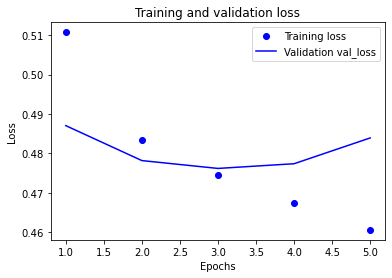

In [ ]:
import matplotlib.pyplot as plt

print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation val_loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
# 모델 로드 및 테스트
from transformers import TFGPT2LMHeadModel, AutoTokenizer
from timeit import default_timer

print("[모델 로딩 시간]")
start = default_timer()

loaded_model = TFGPT2LMHeadModel.from_pretrained("output/finetuned-kogpt2-cs-comment-generation-epoch1")
loaded_tokenizer = AutoTokenizer.from_pretrained("output/finetuned-kogpt2-cs-comment-generation-epoch1")

end = default_timer()
print("Time duration(in seconds):", end - start)

print("[문장 생성 시간]")
start = default_timer()

prompt = "환불 요청 안함 | 탑승 전 | 엑셀,바퀴 | 엑셀이 작동을 안해요"
input_ids = loaded_tokenizer.encode(prompt, return_tensors="tf")
output_ids = loaded_model.generate(input_ids=input_ids,
                                   max_length=200+input_ids.shape[1],
                                   num_beams=1, # Higher value increases the computational cost
                                   no_repeat_ngram_size=1, # Higher means more repetitive words
                                   repetition_penalty=2.0, # Higher avoids repeating sentences
                                   temperature=0.1, # Higher means more diverse : 0 ~ 1
                                   top_p=0.9, # Higher means more diverse : 0 ~ 1
                                   early_stopping=True)
generated_text = loaded_tokenizer.decode(output_ids[0], skip_special_tokens=True)

print("Prompt: " + prompt)

split_generated_text = generated_text.split(prompt)
if len(split_generated_text) > 1:
    generated_text = split_generated_text[1]
# Trim the sentences after the last period(.)
text_to_remove = generated_text.split('.')[-1]
generated_text = generated_text.replace(text_to_remove,'')
print("Generated text: " + generated_text)

end = default_timer()
print("Time duration(in seconds):", end - start)

In [ ]:
# 에폭 한번 학습당 약 24시간(하루) 걸림 @ No GPU
# Normal fine-tuning steps are around 10000s
# and the number of epochs are around 10s
print_current_datetime()

print("[모델 학습 시간]")
start = default_timer()

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss)

history = model.fit(train_input_ids, train_output_ids,
          validation_data=(val_input_ids,val_output_ids),
          batch_size = 4, # 약 12GB 메모리사용
          epochs = 1)

end = default_timer()
print("Time duration(in seconds):", end - start)

print_current_datetime()

print("[문장 생성 시간]")
start = default_timer()

# Generate text from prompt :
# In text generation tasks, a 2-gram refers to a sequence of two consecutive words
# and early_stopping parameter specifies whether to stop generation as soon as
# all beam hypotheses (num_beams=5) have generated an end-of-sequence token
prompt = "환불 요청 안함 | 탑승 전 | 엑셀,바퀴 | 엑셀이 작동을 안해요"
input_ids = tokenizer.encode(prompt, return_tensors="tf")
output_ids = model.generate(input_ids=input_ids, max_length=280, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

print("Prompt: " + prompt)
print("Generated text: " + generated_text)

end = default_timer()
print("Time duration(in seconds):", end - start)

# 모델 저장

model.save_pretrained("output/finetuned-kogpt2-cs-comment-generation-epoch1")
tokenizer.save_pretrained("output/finetuned-kogpt2-cs-comment-generation-epoch1")

CDT(Current Date and Time): 2023-03-15 16:32:10.822238
[모델 학습 시간]


/home/gbike/anaconda3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py:377: FutureWarning: The old compute_loss method is deprecated as it conflicts with the Keras compute_loss method added in TF 2.8. If you want the original HF compute_loss, please call hf_compute_loss() instead. From TF versions >= 2.8, or Transformers versions >= 5, calling compute_loss() will get the Keras method instead.
  return py_builtins.overload_of(f)(*args)


26462/26462 [==============================] - 86261s 3s/step - loss: 0.5165 - val_loss: 0.4861
Time duration(in seconds): 86261.62590811285
CDT(Current Date and Time): 2023-03-16 16:29:52.448478
[문장 생성 시간]
Prompt: 환불 요청 안함 | 탑승 전 | 엑셀,바퀴 | 엑셀이 작동을 안해요
Generated text: 환불 요청 안함 | 탑승 전 | 엑셀,바퀴 | 엑셀이 작동을 안해요 수거/점검 진행하도록 하겠습니다. 감사합니다. 또한,기는팀 점검하였습니다. 확인하여 이용에드 않도록하겠 감사 접수 꼼꼼히 확인 진행할 있도록습니다. 더욱 하겠 빠른릴 수 노력 운영립니다.합니다.습니다.합니다.합니다. 감사 감사 하겠 감사 수합니다. 노력 감사하겠 감사습니다.습니다.으로 불편 기 드 서비스 해당하여으로습니다. 접수합니다. 꼼꼼히리지시 부탁드리해 보려 반납겠며, 후 점 불편을 종료실 죄하다는 고객송 다시 번 환 양 답 이용어진될 신고금셔 도와하 미니 시 늦변일 경우구역 가능지면 참고 영업되 주차 기기 카드다 소요신 결제 확인 감사팀습니다. 확인 확인습니다. 수습니다.팀 감사 접수 접수 감사드습니다.드 감사 확인으로합니다. 수 감사 점검 감사 꼼꼼히 감사으로 감사하여 감사 운영 감사 노력합니다.팀팀합니다.으로 확인합니다. 확인
Time duration(in seconds): 107.95419706590474


('output/finetuned-kogpt2-cs-comment-generation-epoch1/tokenizer_config.json',
 'output/finetuned-kogpt2-cs-comment-generation-epoch1/special_tokens_map.json',
 'output/finetuned-kogpt2-cs-comment-generation-epoch1/vocab.json',
 'output/finetuned-kogpt2-cs-comment-generation-epoch1/merges.txt',
 'output/finetuned-kogpt2-cs-comment-generation-epoch1/added_tokens.json',
 'output/finetuned-kogpt2-cs-comment-generation-epoch1/tokenizer.json')